In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

# symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "AMZN"]
symbols = ["AAPL", "NVDA"]

    # Today's date

# Define the stock symbol and the time period


def get_symbol(symbol,start_date,end_date):
        # Fetch historical data
    filename = f"{symbol}_{start_date}_to_{end_date}.csv"
    if os.path.exists(filename):
        print("CSV exists, skipping download:", filename)
    else:
        data = yf.download(symbol, start=start_date, end=end_date)
        data.to_csv(filename)
        print("Saved CSV:", filename)
    return filename

        
symbol = "AAPL"
start_date = "2007-10-26"  # 16 years ago from today
end_date = "2023-10-26"
filename = get_symbol(symbol,start_date,end_date)
# load CSV back into `data`
data = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Loaded CSV:", filename, "rows:", len(data))
# show data head


# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()


CSV exists, skipping download: AAPL_2007-10-26_to_2023-10-26.csv
Loaded CSV: AAPL_2007-10-26_to_2023-10-26.csv rows: 4029


C:\Users\Lau\AppData\Local\Temp\ipykernel_36692\646950196.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
0,2007-10-26,5.5447163581848145,5.564829497112659,5.490079692256492,5.562427832569194,706876800
1,2007-10-29,5.556423187255859,5.601453992711896,5.544715875249831,5.5672302759483365,540554000
2,2007-10-30,5.613760948181152,5.684908641045085,5.545615335321901,5.58914469376627,939414000
3,2007-10-31,5.702322959899902,5.707426097114006,5.55222210680659,5.632675477874619,833310800
4,2007-11-01,5.62697172164917,5.706825469537038,5.403621714682212,5.661794657302665,805036400


In [26]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [27]:
# ...existing code...
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Parameters (tune as needed)
SEQ_LEN = 60        # number of past days used to predict
FORCAST = 14        # predict 20 days ahead (target is the value forcast steps after the input window)
BATCH_SIZE = 64
TRAIN_RATIO = 0.8

# 1) prepare series (use Close price)
series = data["Close"].dropna().values.astype(np.float32).reshape(-1, 1)
n_total = len(series)
if n_total < SEQ_LEN + FORCAST:
    raise ValueError("Not enough data for the chosen SEQ_LEN/forcast")

# 2) train / test split indices for scaling (avoid leakage)
train_end = int(n_total * TRAIN_RATIO)
train_series = series[:train_end]
# MinMax scaler using train set
train_min = train_series.min(axis=0)
train_max = train_series.max(axis=0)
scale_denom = (train_max - train_min)
scale_denom[scale_denom == 0] = 1.0  # avoid div by zero

def scale(x):
    return (x - train_min) / scale_denom

series_scaled = scale(series)
print("Series scaled shape:", series_scaled.shape)  # (n_total, 1)
# 3) create sequences and targets
def create_sequences(data_arr, seq_len, forcast):
    xs, ys = [], []
    for i in range(0, len(data_arr) - seq_len - (forcast - 1)):
        x = data_arr[i : i + seq_len]
        y = data_arr[i + seq_len + (forcast - 1)]
        xs.append(x)
        ys.append(y)
    return np.stack(xs), np.stack(ys)

X_all, y_all = create_sequences(series_scaled, SEQ_LEN, FORCAST)

print("X_all shape:", X_all.shape)  # (N, SEQ_LEN, 1)
print("y_all shape:", y_all.shape)  # (N, 1)
# 4) split sequences into train / test by sequence count
n_seq = len(X_all)
train_seq_count = int(n_seq * TRAIN_RATIO)

X_train, y_train = X_all[:train_seq_count], y_all[:train_seq_count]
X_test,  y_test  = X_all[train_seq_count:], y_all[train_seq_count:]

# 5) Dataset wrapper
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()       # shape: (N, seq_len, 1)
        self.y = torch.from_numpy(y).float()       # shape: (N, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(X_train, y_train)
test_dataset  = SequenceDataset(X_test,  y_test)

# 6) DataLoaders (assign train_loader as requested)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# 7) quick sanity print
print(f"Total series length: {n_total}, sequences: {n_seq}")
print(f"Train sequences: {len(train_dataset)}, Test sequences: {len(test_dataset)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# ...existing code...


Series scaled shape: (4027, 1)
X_all shape: (3954, 60, 1)
y_all shape: (3954, 1)
Total series length: 4027, sequences: 3954
Train sequences: 3163, Test sequences: 791
X_train shape: (3163, 60, 1), y_train shape: (3163, 1)


In [28]:
import platform


# device selection: prefer CUDA only when running on Windows and CUDA is available
device = torch.device("cuda" if (platform.system() == "Windows" and torch.cuda.is_available()) else "cpu")
print("Platform:", platform.system(), "CUDA available:", torch.cuda.is_available(), "Using device:", device)


Platform: Windows CUDA available: True Using device: cuda


In [ ]:
# training hyperparams

# hidden state size used by NaiveCustomLSTM 
ISTRAIN = True
HIDDEN_SIZE = 64  
# LR = 1e-3  
LR = 0.05
EPOCHS = 100  

# model + simple linear head that maps last hidden state -> scalar prediction
model = NaiveCustomLSTM(input_sz=1, hidden_sz=HIDDEN_SIZE).to(device)
# head = nn.Linear(HIDDEN_SIZE, 1).to(device)
head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(HIDDEN_SIZE, 1)
).to(device)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=LR)

In [30]:


def start_train():
    for epoch in range(1, EPOCHS + 1):
        model.train()
        head.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)          # shape: (B, seq_len, 1)
            yb = yb.to(device)          # shape: (B, 1)
            optimizer.zero_grad()
            out_seq, _ = model(xb)      # out_seq: (B, seq_len, hidden)
            last_h = out_seq[:, -1, :]  # take last time-step hidden (B, hidden)
            preds = head(last_h)        # (B, 1)
            # compute loss between model predictions and targets (e.g., MSE)
            loss = criterion(preds, yb)
            # backpropagate gradients through model and head parameters
            loss.backward()
            # apply optimizer step to update parameters (Adam)
            optimizer.step() 
            running_loss += loss.item() * xb.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # validation / test eval
        model.eval()
        head.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                out_seq, _ = model(xb)
                preds = head(out_seq[:, -1, :])
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss = val_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else float("nan")

        print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.6f}  val_loss: {val_loss:.6f}")
        
        # export model
        torch.save({
            'model_state_dict': model.state_dict(),
            'head_state_dict': head.state_dict(),
        }, 'lstm_price_model.pth')

if ISTRAIN :
    start_train()


Epoch 1/200 — train_loss: 0.017333  val_loss: 0.018801
Epoch 2/200 — train_loss: 0.001503  val_loss: 0.007461
Epoch 3/200 — train_loss: 0.001281  val_loss: 0.018541
Epoch 4/200 — train_loss: 0.001094  val_loss: 0.100831
Epoch 5/200 — train_loss: 0.001053  val_loss: 0.086347
Epoch 6/200 — train_loss: 0.001000  val_loss: 0.066450
Epoch 7/200 — train_loss: 0.001021  val_loss: 0.048758
Epoch 8/200 — train_loss: 0.001054  val_loss: 0.025034
Epoch 9/200 — train_loss: 0.000913  val_loss: 0.060093
Epoch 10/200 — train_loss: 0.000844  val_loss: 0.232740
Epoch 11/200 — train_loss: 0.000996  val_loss: 0.307870
Epoch 12/200 — train_loss: 0.000783  val_loss: 0.106522
Epoch 13/200 — train_loss: 0.000798  val_loss: 0.173144
Epoch 14/200 — train_loss: 0.000805  val_loss: 0.161565
Epoch 15/200 — train_loss: 0.000784  val_loss: 0.066546
Epoch 16/200 — train_loss: 0.000901  val_loss: 0.220701
Epoch 17/200 — train_loss: 0.000907  val_loss: 0.191413
Epoch 18/200 — train_loss: 0.000866  val_loss: 0.162918
E

In [31]:
# load checkpoint (use in-memory ckpt if present, otherwise load file)
state =  torch.load('lstm_price_model.pth', map_location=device)
print(state['model_state_dict'].keys())
print(state['head_state_dict'].keys())

odict_keys(['W_i', 'U_i', 'b_i', 'W_f', 'U_f', 'b_f', 'W_c', 'U_c', 'b_c', 'W_o', 'U_o', 'b_o'])
odict_keys(['1.weight', '1.bias'])


In [32]:


# load weights
model.load_state_dict(state['model_state_dict'])
head.load_state_dict(state['head_state_dict'])

model.eval()
head.eval()

# prepare test data tensor
X_test_tensor = torch.from_numpy(X_test).float().to(device)  # shape: (N, seq_len, 1)

# batch inference
preds_batches = []
with torch.no_grad():
    for i in range(0, X_test_tensor.size(0), BATCH_SIZE):
        xb = X_test_tensor[i : i + BATCH_SIZE]
        out_seq, _ = model(xb)
        preds = head(out_seq[:, -1, :])        # shape (B,1)
        if i == 0:
          print(out_seq.shape, out_seq[:, -1, :].shape)

          print(preds.shape)
          print(preds[:5])
        preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
# show list length and shapes of elements and total concatenated shape

print("preds_batches shape:",len(preds_batches), len(preds_batches[0]))
print("preds_batches first:",preds_batches[0])







torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[1.1661],
        [1.1633],
        [1.1731],
        [1.1784],
        [1.2060]], device='cuda:0')
preds_batches shape: 13 64
preds_batches first: tensor([[1.1661],
        [1.1633],
        [1.1731],
        [1.1784],
        [1.2060],
        [1.2794],
        [1.3183],
        [1.3144],
        [1.3319],
        [1.3245],
        [1.3177],
        [1.3634],
        [1.4348],
        [1.4262],
        [1.3027],
        [1.2687],
        [1.1814],
        [1.1965],
        [1.1698],
        [1.1364],
        [1.1662],
        [1.1777],
        [1.1411],
        [1.1109],
        [1.0685],
        [1.0899],
        [1.1180],
        [1.0733],
        [1.0696],
        [1.1159],
        [1.1566],
        [1.1565],
        [1.1722],
        [1.1897],
        [1.1537],
        [1.1780],
        [1.1558],
        [1.1635],
        [1.1700],
        [1.1897],
        [1.2747],
        [1.2675],
        [1.2573],
    

In [33]:
preds_scaled = torch.cat(preds_batches, dim=0)
print("before:", preds_scaled.shape)
preds_scaled = preds_scaled.squeeze(-1).numpy()  # shape: (N,)
print("after:", preds_scaled.shape)
print(y_test.shape)


before: torch.Size([791, 1])
after: (791,)
(791, 1)


In [34]:
# inverse scale to original price units
preds_unscaled = preds_scaled * scale_denom + train_min


# optional: compare first 10 predictions with scaled targets (and unscale targets)
y_test_unscaled = y_test * scale_denom + train_min


print("len of all", len(preds_unscaled), len(y_test_unscaled))

len of all 791 791


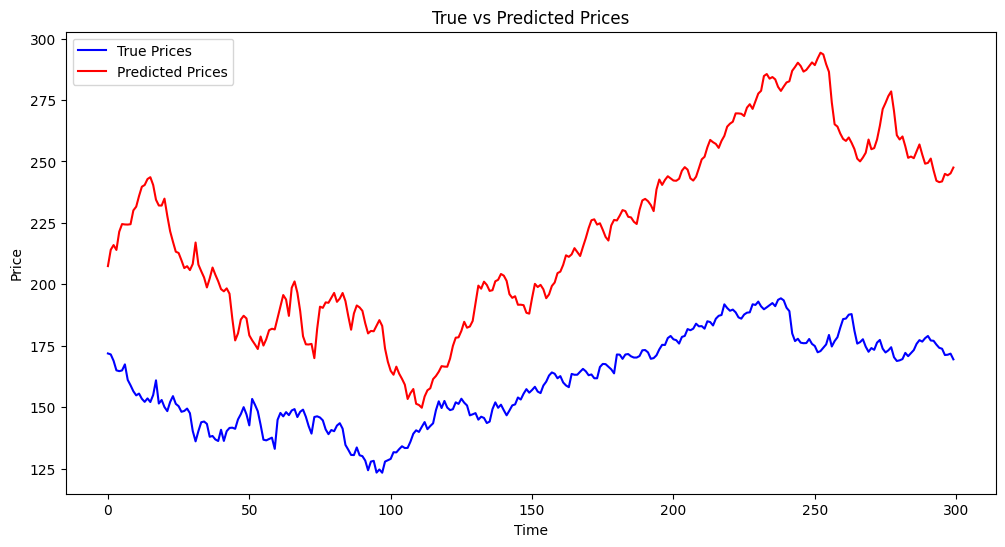

In [35]:
#matplotlib inline showing predicted vs true prices
import matplotlib.pyplot as plt
CLIP = 300
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled[-CLIP:], label='True Prices', color='blue')
plt.plot(preds_unscaled[-CLIP:], label='Predicted Prices', color='red')
# true close price at "now" (last value of each input window, not the FORCAST target)
# plt.plot((X_test[:, -1, 0] * scale_denom + train_min)[CLIP:], label='True Prices (now)', color='green', alpha=0.25)
plt.title('True vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [36]:
symbol = "GOOGL"
start_date = "2007-10-26"
end_date = "2023-10-26"

# call get_symbol (it saves the CSV but doesn't return the filename), then build filename explicitly
filename = get_symbol(symbol, start_date, end_date)

if not os.path.exists(filename):
    raise FileNotFoundError(f"Expected CSV not found: {filename}")

data = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Loaded CSV:", filename, "rows:", len(data))

# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()

CSV exists, skipping download: GOOGL_2007-10-26_to_2023-10-26.csv
Loaded CSV: GOOGL_2007-10-26_to_2023-10-26.csv rows: 4029


C:\Users\Lau\AppData\Local\Temp\ipykernel_36692\3565596129.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
0,2007-10-26,16.76624298095703,16.814458179858924,16.603700193380917,16.75207752865717,134021844
1,2007-10-29,16.88131332397461,16.900451268636452,16.703858754245147,16.845026432166012,122529348
2,2007-10-30,17.267541885375977,17.39528858893169,16.838568083556286,16.838568083556286,275747976
3,2007-10-31,17.57149887084961,17.57149887084961,17.29910282561521,17.414671155879713,274796928
4,2007-11-01,17.477306365966797,17.73851670753434,17.441763922939312,17.466866969093992,260826912


In [37]:
# predict  price using the loaded model + head
# (uses existing variables: model, head, device, SEQ_LEN, FORCAST, scale, train_min, scale_denom)

series_nvda = data["Close"].dropna().values.astype(np.float32).reshape(-1, 1)

print(series_nvda)
series_nvda_scaled = scale(series_nvda)

print("series scaled shape:", series_nvda_scaled.shape)  # (n_total, 1)
# create sequences for  (reuse create_sequences from notebook)
X_nvda, y_nvda = create_sequences(series_nvda_scaled, SEQ_LEN, FORCAST)
print("X y shape:", X_nvda.shape, y_nvda.shape)  # (N, SEQ_LEN, 1)
if len(X_nvda) == 0:
    raise RuntimeError("Not enough NVDA data to build a sequence with the configured SEQ_LEN/FORCAST.")







[[ 16.766243]
 [ 16.881313]
 [ 17.267542]
 ...
 [135.565   ]
 [137.85918 ]
 [124.74958 ]]
series scaled shape: (4027, 1)
X y shape: (3954, 60, 1) (3954, 1)


torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[0.0945],
        [0.0999],
        [0.0994],
        [0.0969],
        [0.0953]], device='cuda:0')
now prices shape: (4027,)
len of all 3954 3954 4027


C:\Users\Lau\AppData\Local\Temp\ipykernel_36692\4111742558.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_nvda_unscaled = preds_nvda_scaled * scale_denom + train_min


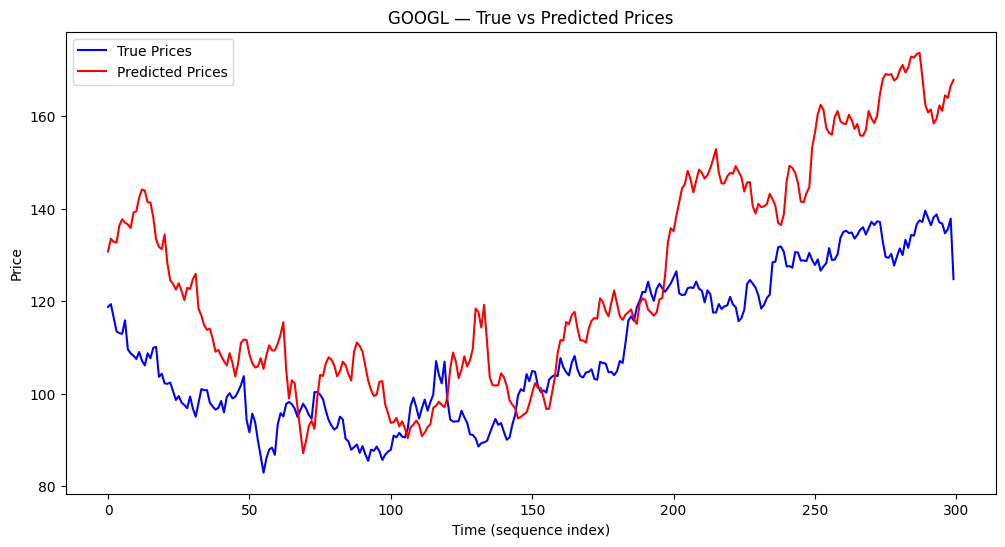

In [38]:

# prepare NVDA input tensor and run batch inference
X_nvda_tensor = torch.from_numpy(X_nvda).float().to(device)  # (N, seq_len, 1)
preds_batches = []


with torch.no_grad():
    for i in range(0, X_nvda_tensor.size(0), BATCH_SIZE):
        xb = X_nvda_tensor[i : i + BATCH_SIZE]
        out_seq, _ = model(xb)
        preds = head(out_seq[:, -1, :])        # shape (B,1)
        if i == 0:
          print(out_seq.shape, out_seq[:, -1, :].shape)

          print(preds.shape)
          print(preds[:5])
        preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
        
preds_nvda_scaled = torch.cat(preds_batches, dim=0).squeeze()   # shape matches preds_nvda_unscaled

# inverse scale to original price units
preds_nvda_unscaled = preds_nvda_scaled * scale_denom + train_min
y_nvda_unscaled = (y_nvda * scale_denom + train_min).squeeze()           # (N,)
now_prices = series_nvda.squeeze()   # last value of each input window
print("now prices shape:", now_prices.shape)
print("len of all",len(preds_nvda_scaled), len(y_nvda_unscaled), len(now_prices))

# clipped to last 300
CLIP = 300

# plot
plt.figure(figsize=(12,6))
plt.plot(y_nvda_unscaled[-CLIP:], label='True Prices', color='blue')
plt.plot(preds_nvda_unscaled[-CLIP:], label='Predicted Prices', color='red')
# plt.plot(now_prices[-CLIP:], label='True Prices (now)', color='green', alpha=0.25)
plt.title(f'{symbol} — True vs Predicted Prices')
plt.xlabel('Time (sequence index)')
plt.ylabel('Price')
plt.legend()
plt.show()